In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import scipy.cluster
from xgboost import XGBRegressor
import numpy as np
import shap

seed = 2023
np.random.seed(seed)

In [2]:
X, y = shap.datasets.california()
model = XGBRegressor(n_estimators=100, subsample=0.3)
model.fit(X, y)

instance = X[0:1]
references = X[1:100]

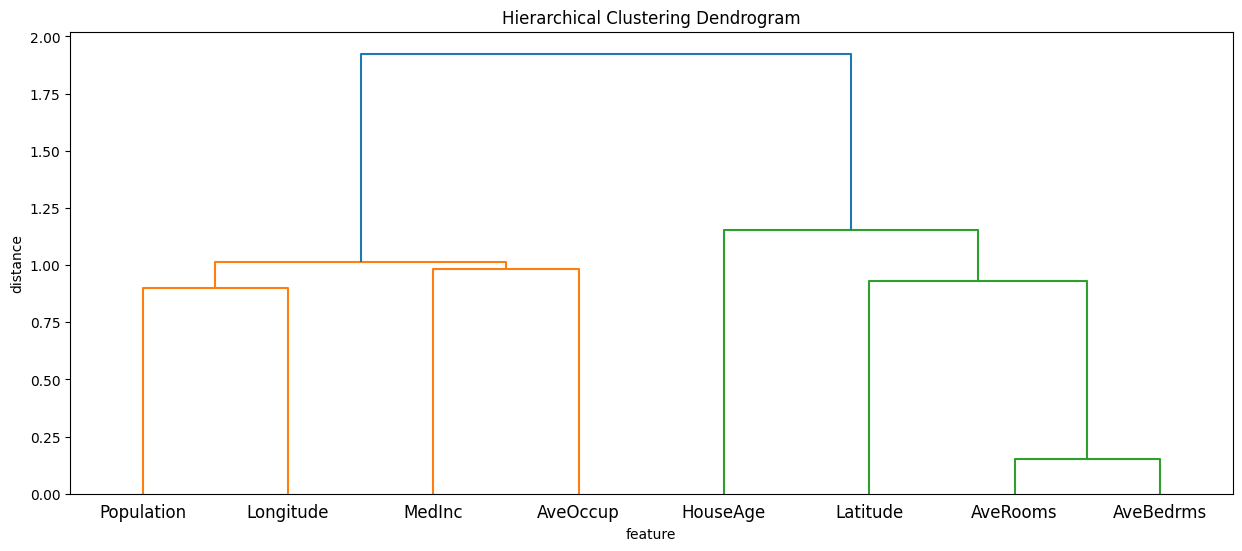

In [3]:
partition_clustering = shap.utils.partition_tree(X)
plt.figure(figsize=(15, 6))
sp.cluster.hierarchy.dendrogram(partition_clustering , labels=X.columns)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("feature")
plt.ylabel("distance")
plt.show()

In [4]:
partition_hierarchy = {
    'cluster_12': {
        'cluster_11': {
            'AveOccup': 'AveOccup',
            'MedInc': 'MedInc'
        },
        'cluster_9': {
            'Longitude': 'Longitude',
            'Population': 'Population'
        }
    },
    'cluster_13': {
        'HouseAge': 'HouseAge',
        'cluster_10': {
            'Latitude': 'Latitude',
            'cluster_8': {
                'AveBedrms': 'AveBedrms',
                'AveRooms': 'AveRooms'
            }
        }
    }
}

In [156]:
import queue  # multi-producer, multi-consumer queues
import time  # time execution

import numpy as np  # numpy base
from numba import njit  # just in time compiler
from tqdm.auto import tqdm  # progress bar

from shap import Explanation, links  # shap modules
from shap.explainers._explainer import Explainer
from shap.models import Model
from shap.utils import MaskedModel, OpChain, make_masks, safe_isinstance
from itertools import chain, combinations, product

class PartitionExplainer2(Explainer):
    """Uses the Partition SHAP method to explain the output of any function.
    The method has two options:
    1. The Cluster method. Users can pass or call a scipy hierarchy of the features using any distance measure.
    2. The custom Partition method. Users can pass any nested dictionaries of the feature coalitions.

    Partition SHAP computes Shapley values recursively through a hierarchy of features, this
    hierarchy defines feature coalitions and results in the Winter values from game theory.

    The Cluster method has two particularly nice properties:

    1) PartitionExplainer is model-agnostic but when using a balanced partition tree only has
       quadratic exact runtime (in term of the number of input features). This is in contrast to the
       exponential exact runtime of KernelExplainer or SamplingExplainer.
    2) PartitionExplainer always assigns to groups of correlated features the credit that set of features
       would have had if treated as a group. This means if the hierarchical clustering given to
       PartitionExplainer groups correlated features together, then feature correlations are
       "accounted for" in the sense that the total credit assigned to a group of tightly dependent features
       does not depend on how they behave if their correlation structure was broken during the explanation's
       perturbation process.
    Note that for linear models the Winter values that PartitionExplainer returns are the same as the standard
    non-hierarchical Shapley values.



    """

    def __init__(
        self,
        model,
        masker,
        *,
        output_names=None,
        link=links.identity,
        linearize_link=True,
        feature_names=None,
        partition_tree=None,
        **call_args,
    ):
        """Build a PartitionExplainer for the given model with the given masker.

        Parameters
        ----------
        model : function
            User supplied function that takes a matrix of samples (# samples x # features) and
            computes the output of the model for those samples.

        masker : function or numpy.array or pandas.DataFrame or tokenizer
            The function used to "mask" out hidden features of the form `masker(mask, x)`. It takes a
            single input sample and a binary mask and returns a matrix of masked samples. These
            masked samples will then be evaluated using the model function and the outputs averaged.
            As a shortcut for the standard masking using by SHAP you can pass a background data matrix
            instead of a function and that matrix will be used for masking. Domain specific masking
            functions are available in shap such as shap.maksers.Image for images and shap.maskers.Text
            for text.

        partition_tree : Nested dictionary of features  ################################ NOT CURRENTLY IMPLEMENTED #####################################
            A hierarchical clustering of the input features represented by a matrix that follows the format
            used by scipy.cluster.hierarchy (see the notebooks_html/partition_explainer directory an example).
            If this is a function then the function produces a clustering matrix when given a single input
            example. If you are using a standard SHAP masker object then you can pass masker.clustering
            to use that masker's built-in clustering of the features, or if partition_tree is None then
            masker.clustering will be used by default.

        Examples
        --------
        See `Partition explainer examples <https://shap.readthedocs.io/en/latest/api_examples/explainers/PartitionExplainer.html>`_

        """
        super().__init__(
            model,
            masker,
            link=link,
            linearize_link=linearize_link,
            algorithm="partition",
            output_names=output_names,
            feature_names=feature_names,
        )

        # convert dataframes
        # if isinstance(masker, pd.DataFrame):
        #     masker = TabularMasker(masker)
        # elif isinstance(masker, np.ndarray) and len(masker.shape) == 2:
        #     masker = TabularMasker(masker)
        # elif safe_isinstance(masker, "transformers.PreTrainedTokenizer"):
        #     masker = TextMasker(masker)
        # self.masker = masker

        # TODO: maybe? if we have a tabular masker then we build a PermutationExplainer that we
        # will use for sampling
        self.input_shape = (
            masker.shape[1:]
            if hasattr(masker, "shape") and not callable(masker.shape)
            else None
        )
        # self.output_names = output_names
        if not safe_isinstance(self.model, "shap.models.Model"):
            self.model = Model(self.model)  # lambda *args: np.array(model(*args))
        self.expected_value = None
        self._curr_base_value = None

        # handle higher dimensional tensor inputs
        if self.input_shape is not None and len(self.input_shape) > 1:
            self._reshaped_model = lambda x: self.model(
                x.reshape(x.shape[0], *self.input_shape)
            )
        else:
            self._reshaped_model = self.model

        self.partition_tree = partition_tree
        if partition_tree is not None:

            self.root = Node("Root")
            build_tree(partition_tree, self.root)
            self.combinations_list = generate_paths_and_combinations(self.root)
            self.masks, self.keys = create_masks1(self.root, self.masker.feature_names)
            self.masks_dict = dict(zip(self.keys, self.masks))
            self.unique_masks = create_combined_masks(self.combinations_list, self.masks_dict)
            self.unique_masks_list = [mask for _, mask in self.unique_masks]
            self.unique_masks_set = set(map(tuple, self.unique_masks_list))
            self.unique_masks = [np.array(mask) for mask in self.unique_masks_set]
            self._clustering = None  # Ensure _clustering is None when using partition_tree
        else:
            if not hasattr(masker, "clustering"):
                raise ValueError(
                    "The passed masker does not have masker.clustering, so the partition_tree must be passed!"
                )
            self._clustering = masker.clustering
            if not callable(masker.clustering):
                self._mask_matrix = make_masks(self._clustering)

        # if getattr(self.masker, "clustering", None) is None:
        #     raise ValueError(
        #         "The passed masker must have a .clustering attribute defined! Try shap.maskers.Partition(data) for example."
        #     )

        # if partition_tree is None:
        #     if not hasattr(masker, "partition_tree"):
        #         raise ValueError(
        #             "The passed masker does not have masker.clustering, so the partition_tree must be passed!"
        #         )
        #     self.partition_tree = masker.clustering
        # else:
        #     self.partition_tree = partition_tree
        # if we don't have a dynamic clustering algorithm then can precowe mpute
        # a lot of information
        # if not callable(self.masker.clustering):
        #     self._clustering = self.masker.clustering  #
        #     self._mask_matrix = make_masks(self._clustering)  # make masks argument

        # if we have gotten default arguments for the call function we need to wrap ourselves in a new class that
        # has a call function with those new default arguments
        if len(call_args) > 0:

            class PartitionExplainer(self.__class__):
                # this signature should match the __call__ signature of the class defined below
                def __call__(
                    self,
                    *args,
                    max_evals=500,
                    fixed_context=None,
                    main_effects=False,
                    error_bounds=False,
                    batch_size="auto",
                    outputs=None,
                    silent=False,
                ):
                    return super().__call__(
                        *args,
                        max_evals=max_evals,
                        fixed_context=fixed_context,
                        main_effects=main_effects,
                        error_bounds=error_bounds,
                        batch_size=batch_size,
                        outputs=outputs,
                        silent=silent,
                    )

            PartitionExplainer.__call__.__doc__ = self.__class__.__call__.__doc__
            self.__class__ = PartitionExplainer
            for k, v in call_args.items():
                self.__call__.__kwdefaults__[k] = v

    # note that changes to this function signature should be copied to the default call argument wrapper above
    def __call__(
        self,
        *args,
        max_evals=500,
        fixed_context=None,
        main_effects=False,
        error_bounds=False,
        batch_size="auto",
        outputs=None,
        silent=False,
    ):
        """Explain the output of the model on the given arguments."""
        return super().__call__(
            *args,
            max_evals=max_evals,
            fixed_context=fixed_context,
            main_effects=main_effects,
            error_bounds=error_bounds,
            batch_size=batch_size,
            outputs=outputs,
            silent=silent,
        )

    def explain_row(
        self,
        *row_args,
        max_evals,
        main_effects,
        error_bounds,
        batch_size,
        outputs,
        silent,
        fixed_context="auto",
    ):
        if fixed_context == "auto":
            fixed_context = None
        elif fixed_context not in [0, 1, None]:
            raise ValueError(
                "Unknown fixed_context value passed (must be 0, 1 or None): %s"
                % fixed_context
            )

        fm = MaskedModel(
            self.model, self.masker, self.link, self.linearize_link, *row_args
        )
        M = len(fm)
        m00 = np.zeros(M, dtype=bool)
        if self._curr_base_value is None or not getattr(
            self.masker, "fixed_background", False
        ):
            self._curr_base_value = fm(m00.reshape(1, -1), zero_index=0)[0]
        f11 = fm(~m00.reshape(1, -1))[0]

        if self.partition_tree is not None:
            return self.explain_with_partition_tree(fm, self._curr_base_value, f11, max_evals, outputs, fixed_context, batch_size, silent)
        else:
            return self.explain_with_clustering(fm, self._curr_base_value, f11, max_evals, outputs, fixed_context, batch_size, silent)

    def explain_with_clustering(
        self, fm, f00, f11, max_evals, outputs, fixed_context, batch_size, silent
    ):
        if callable(self.masker.clustering):
            self._clustering = self.masker.clustering(*row_args)
            self._mask_matrix = make_masks(self._clustering)
        M = len(fm)
        m00 = np.zeros(M, dtype=bool)
        if (
            hasattr(self._curr_base_value, "shape")
            and len(self._curr_base_value.shape) > 0
        ):
            if outputs is None:
                outputs = np.arange(len(self._curr_base_value))
            elif isinstance(outputs, OpChain):
                outputs = outputs.apply(Explanation(f11)).values

            out_shape = (2 * self._clustering.shape[0] + 1, len(outputs))
        else:
            out_shape = (2 * self._clustering.shape[0] + 1,)

        if max_evals == "auto":
            max_evals = 500

        self.values = np.zeros(out_shape)
        self.dvalues = np.zeros(out_shape)

        self.owen(
            fm,
            self._curr_base_value,
            f11,
            max_evals - 2,
            outputs,
            fixed_context,
            batch_size,
            silent,
        )
        self.values[:] = self.dvalues  # Assign dvalues to values
        lower_credit(len(self.dvalues) - 1, 0, M, self.values, self._clustering)
        return {
            "values": self.values[:M].copy(),
            "expected_values": self._curr_base_value
            if outputs is None
            else self._curr_base_value[outputs],
            "mask_shapes": [s + out_shape[1:] for s in fm.mask_shapes],
            "main_effects": None,
            "hierarchical_values": self.dvalues.copy(),
            "clustering": self._clustering,
            "output_indices": outputs,
            "output_names": getattr(self.model, "output_names", None),
        }

    def explain_with_partition_tree(
        self, fm, f00, f11, max_evals, outputs, fixed_context, batch_size, silent
    ):
        # Step 1: Generate all unique masks
        self.root = Node("Root")
        build_tree(self.partition_tree, self.root)
        self.combinations_list = generate_paths_and_combinations(self.root)
        self.masks, self.keys = create_masks1(self.root, self.masker.feature_names)
        self.masks_dict = dict(zip(self.keys, self.masks))
        self.mask_permutations = create_combined_masks(self.combinations_list, self.masks_dict)
        self.masks_list = [mask for _, mask in self.mask_permutations]
        self.unique_masks_set = set(map(tuple, self.masks_list))
        self.unique_masks = [np.array(mask) for mask in self.unique_masks_set]

        # Step 2: Compute model results for all unique masks
        mask_results = {}
        for mask in self.unique_masks:
            print(mask)
            result = fm(mask.reshape(1, -1))
            print("model results", result)
            mask_results[tuple(mask)] = result

        # Step 3: Compute marginals for permutations
        shap_values = np.zeros(len(fm))
        last_key_to_off_indexes, last_key_to_on_indexes = map_combinations_to_unique_masks(
            self.mask_permutations, self.unique_masks
            )

        feature_name_to_index = {name: idx for idx, name in enumerate(self.masker.feature_names)}
        print(feature_name_to_index)

        for last_key in last_key_to_off_indexes:
            off_indexes = last_key_to_off_indexes[last_key]
            on_indexes = last_key_to_on_indexes[last_key]
            num_permutations = len(off_indexes)

            for off_index, on_index in zip(off_indexes, on_indexes):
                off_result = mask_results[tuple(self.unique_masks[off_index])]
                on_result = mask_results[tuple(self.unique_masks[on_index])]

                print("off", off_index, off_result,"on", on_index, on_result, num_permutations)
                print("the values", (on_result - off_result) / num_permutations)
                marginal_contribution = (on_result - off_result) /num_permutations
                print("the marginal", marginal_contribution)
                shap_values[feature_name_to_index[last_key]] += marginal_contribution.item()
        # Step 4: Return results
        return {
            "values": shap_values,
            "expected_values": f00,
            "mask_shapes": [s + (len(fm.mask_shapes[0]),) for s in fm.mask_shapes],
            "main_effects": None,
            "hierarchical_values": shap_values,
            "clustering": None,
            "output_indices": outputs,
            "output_names": getattr(self.model, "output_names", None),
        }

    def __str__(self):
        return "shap.explainers.PartitionExplainer()"

    ################
    # owen3 has a more efficient strategy dynamically adjusting the context and the number of evaluations
    # I removed it for now to understand the method
    ###############

    ###################### MAIN FUNCTION THAT CALCULATES THE WINTER VALUES #####################

    def owen(
        self, fm, f00, f11, max_evals, output_indexes, fixed_context, batch_size, silent
    ):
        """Compute a nested set of recursive Owen values based on an ordering recursion."""
        # f = self._reshaped_model
        # r = self.masker
        # masks = np.zeros(2*len(inds)+1, dtype=int)
        M = len(fm)  # number of features
        m00 = np.zeros(
            M, dtype=bool
        )  # all false mask       #f00 = fm(m00.reshape(1,-1))[0] = fm(m00.reshape(1, -1), zero_index=0)[0]
        base_value = f00  # baseline value calculated outside assigneed here only used in the output??????
        # f11 = fm(~m00.reshape(1,-1))[0]
        # f11 = self._reshaped_model(r(~m00, x)).mean(0)
        ind = len(self.dvalues) - 1  # index the length of the hierarchy
        #print("ind", ind)

        # make sure output_indexes is a list of indexes
        if output_indexes is not None:
            # assert self.multi_output, "output_indexes is only valid for multi-output models!"
            # inds = output_indexes.apply(f11, 0)
            # out_len = output_indexes_len(output_indexes)
            # if output_indexes.startswith("max("):
            #     output_indexes = np.argsort(-f11)[:out_len]
            # elif output_indexes.startswith("min("):
            #     output_indexes = np.argsort(f11)[:out_len]
            # elif output_indexes.startswith("max(abs("):
            #     output_indexes = np.argsort(np.abs(f11))[:out_len]
            # print(output_indexes) # for this one is none

            f00 = f00[output_indexes]
            f11 = f11[output_indexes]

        q = queue.PriorityQueue()  # setting up priority que
        q.put(
            (0, 0, (m00, f00, f11, ind, 1.0))
        )  # the things in the cue are the all false array, all false value, all true value, length of hierarchy, weight used for the division??
        eval_count = 0  # starting at 0
        total_evals = min(
            max_evals, (M - 1) * M
        )  # TODO: (M-1)*M is only right for balanced clusterings, but this is just for plotting progress...
        pbar = None  # progress bar
        start_time = time.time()  # measure time
        while not q.empty():  #################### go throught the whole que ##############################
            # if we passed our execution limit then leave everything else on the internal nodes
            if eval_count >= max_evals:
                #print("we are doing this")
                while not q.empty():
                    m00, f00, f11, ind, weight = q.get()[2]
                    self.dvalues[ind] += (f11 - f00) * weight
                break

            # create a batch of work to do
            batch_args = []
            batch_masks = []  # batch size is 10 at auto

            # this bit creates the entire list of masks needed recursively
            while (
                not q.empty()
                and len(batch_masks) < batch_size
                and eval_count + len(batch_masks) < max_evals
            ):
                # work until q is not empty or other stop criterion are triggered

                # get our next set of arguments
                m00, f00, f11, ind, weight = q.get()[2]

                # get the left and right children of this cluster
                # print(ind, M)
                lind = int(self._clustering[ind - M, 0]) if ind >= M else -1
                rind = int(self._clustering[ind - M, 1]) if ind >= M else -1

                # get the distance of this cluster's children
                if ind < M:
                    distance = -1
                else:
                    if self._clustering.shape[1] >= 3:
                        distance = self._clustering[ind - M, 2]
                    else:
                        distance = 1

                # check if we are a leaf node (or other negative distance cluster) and so should terminate our decent

                # here we assign self.dvalues by adding the current marginal ##########################
                # it is conditional on the clustering distance
                if distance < 0:
                    # print("the marginals", (f11 - f00) * weight)
                    self.dvalues[ind] += (f11 - f00) * weight
                    # print("updated values", self.dvalues, ind)
                    continue

                # build the masks
                # print(self._clustering)
                m10 = m00.copy()  # we separate the copy from the add so as to not get converted to a matrix
                m10[:] += self._mask_matrix[lind, :]

                # print(self._mask_matrix.toarray())
                # print("the m00", m00)
                # print("the left", lind)
                # print("what we add", self._mask_matrix[lind, :].toarray())
                # print("mask m10", m10)
                m01 = m00.copy()
                m01[:] += self._mask_matrix[rind, :]
                # print("the right", rind)
                # print("what we add", self._mask_matrix[rind, :].toarray())
                # print("mask m01", m01)

                # add the batch
                batch_args.append((m00, m10, m01, f00, f11, ind, lind, rind, weight))
                batch_masks.append(m10)
                batch_masks.append(m01)

            batch_masks = np.array(batch_masks)

            # run the batch calculate the
            if len(batch_args) > 0:
                #print("the masks", batch_masks)
                fout = fm(
                    batch_masks
                )  ######################## call the model using the masks  #############################
                if output_indexes is not None:  # making sure the indexing is correct
                    fout = fout[:, output_indexes]
                #print("output of the model", fout)

                eval_count += len(batch_masks)  # update evaluation count
                # update the progress bar

                if pbar is None and time.time() - start_time > 5:
                    pbar = tqdm(total=total_evals, disable=silent, leave=False)
                    pbar.update(eval_count)
                if pbar is not None:
                    pbar.update(len(batch_masks))

            # use the results of the batch to add new nodes
            # THIS IS HOW THE CODE TRAVERSES THE TREE CREATING ALL POSSIBLE MASKS
            # print(batch_args)
            for i in range(len(batch_args)):
                m00, m10, m01, f00, f11, ind, lind, rind, weight = batch_args[i]

                # get the evaluated model output on the two new masked inputs
                f10 = fout[2 * i]
                f01 = fout[2 * i + 1]

                new_weight = weight
                if fixed_context is None:
                    new_weight /= 2  #
                #print("new weight", new_weight)
                # elif fixed_context == 0:
                #     self.dvalues[ind] += (f11 - f10 - f01 + f00) * weight # leave the interaction effect on the internal node
                # elif fixed_context == 1:
                #     self.dvalues[ind] -= (f11 - f10 - f01 + f00) * weight # leave the interaction effect on the internal node

                ## The idea is to proceed

                if fixed_context is None or fixed_context == 0:
                    # recurse on the left node with zero context
                    args = (m00, f00, f10, lind, new_weight)
                    #print(-np.max(np.abs(f10 - f00)) * new_weight)
                    q.put(
                        (
                            -np.max(np.abs(f10 - f00)) * new_weight,
                            np.random.randn(),
                            args,
                        )
                    )

                    # recurse on the right node with zero context
                    args = (m00, f00, f01, rind, new_weight)
                    #print(-np.max(np.abs(f01 - f00)) * new_weight)
                    q.put(
                        (
                            -np.max(np.abs(f01 - f00)) * new_weight,
                            np.random.randn(),
                            args,
                        )
                    )

                if fixed_context is None or fixed_context == 1:
                    # recurse on the left node with one context
                    args = (m01, f01, f11, lind, new_weight)
                    #print(-np.max(np.abs(f11 - f01)) * new_weight)
                    q.put(
                        (
                            -np.max(np.abs(f11 - f01)) * new_weight,
                            np.random.randn(),
                            args,
                        )
                    )

                    # recurse on the right node with one context
                    args = (m10, f10, f11, rind, new_weight)
                    #print(-np.max(np.abs(f11 - f10)) * new_weight)
                    q.put(
                        (
                            -np.max(np.abs(f11 - f10)) * new_weight,
                            np.random.randn(),
                            args,
                        )
                    )

        if pbar is not None:
            pbar.close()

        self.last_eval_count = eval_count

        return output_indexes, base_value

    ###########################  NOT USED NOW #########################


# def output_indexes_len(output_indexes):
#     if output_indexes.startswith("max("):
#         return int(output_indexes[4:-1])
#     elif output_indexes.startswith("min("):
#         return int(output_indexes[4:-1])
#     elif output_indexes.startswith("max(abs("):
#         return int(output_indexes[8:-2])
#     elif not isinstance(output_indexes, str):
#         return len(output_indexes)


@njit
def lower_credit(i, value, M, values, clustering):
    if i < M:  # M number of features, i
        values[i] += value
        return
    li = int(clustering[i - M, 0])  # get the left index of the top node
    ri = int(clustering[i - M, 1])  # get the right index of the top node
    group_size = int(clustering[i - M, 3])  # get the number of features in the top node
    lsize = int(clustering[li - M, 3]) if li >= M else 1  #
    rsize = int(clustering[ri - M, 3]) if ri >= M else 1
    assert lsize + rsize == group_size
    values[i] += value
    lower_credit(li, values[i] * lsize / group_size, M, values, clustering)
    lower_credit(ri, values[i] * rsize / group_size, M, values, clustering)

# gonna keep the n-ary tree in it's own class for easier referencing
class Node:
    def __init__(self, key):
        self.key = key
        self.child = []
        self.permutations = [] # this may not be the greatest idea??

    def __repr__(self):
        return f"({self.key}): {self.child} -> {self.permutations}"

# This function is to encode the dictionary to our specific structure
def build_tree(d, root):
    if isinstance(d, dict):
        for key, value in d.items():
            node = Node(key)
            root.child.append(node)
            build_tree(value, node)
    elif isinstance(d, list):
        for item in d:
            node = Node(item)
            root.child.append(node)
    # get all the sibling permutations
    generate_permutations(root)

#generate all permutations of sibling nodes and assign it to the nodes
def generate_permutations(node):
    if not node.child:  # Leaf node
        node.permutations = []
        return

    children_keys = [child.key for child in node.child]
    node.permutations = {}

    for i, child in enumerate(node.child):
        excluded = children_keys[:i] + children_keys[i + 1:]
        generate_permutations(child)

        # Generate all unique combinations of permutations for each child
        child.permutations = list(all_subsets(excluded))

def all_subsets(iterable):
    "Return all subsets of a given iterable."
    return chain.from_iterable(combinations(iterable, n) for n in range(len(iterable) + 1))


# Functions to generate the base masks for every node in the hierarchy
def get_all_leaf_values(node):
    leaves = []
    if not node.child:
        leaves.append(node.key)
    else:
        for child in node.child:
            leaves.extend(get_all_leaf_values(child))
    return leaves

def create_masks1(node, columns):
    masks = [np.zeros(len(columns),dtype=bool)] # not very efficient for huge trees? maybe??
    keys = [()]

    if not node.child:  # Check if the child list is empty
        mask = columns == node.key
        masks.append(mask)
        keys.append(node.key)
    else:
        # Create mask for current node
        current_node_mask = columns.isin(get_all_leaf_values(node))
        masks.append(current_node_mask)
        keys.append(node.key)

        # Recursively create masks for all child nodes
        for subset in node.child:
            child_masks, child_keys = create_masks1(subset, columns)
            masks.extend(child_masks)
            keys.extend(child_keys)

    return  masks, keys


# combine all the permutations along depth first traversal
def generate_paths_and_combinations(node):
    paths = []

    def dfs(current_node, current_path):
        current_path.append((current_node.key, current_node.permutations))

        if not current_node.child:  # Leaf node
            paths.append(current_path[:])  # Make a copy of current_path
        else:
            for child in current_node.child:
                dfs(child, current_path)

        current_path.pop()  # Backtrack

    dfs(node, [])

    combinations_list = []

    for path in paths:
        filtered_path = [(key, perms) for key, perms in path if perms]
        if filtered_path:
            node_keys, permutations = zip(*filtered_path)
            path_combinations = list(product(*permutations))
            last_key = node_keys[-1]
            for combination in path_combinations:
                combinations_list.append((last_key, combination))

    return combinations_list

# functions to combine the masks for all the permutations created
def combine_masks(masks):
    combined_mask = np.logical_or.reduce(masks)
    return combined_mask


# def create_combined_masks(combinations, masks_dict):
#     combined_masks = []
#     for last_key, combination in combinations:
#         masks = [masks_dict[key] for keys in combination for key in keys]
#         if masks:
#             combined_mask = combine_masks(masks)
#             combined_masks.append((last_key, combined_mask))

#             # Add the combined mask with the last key's mask
#             if last_key in masks_dict:
#                 combined_mask_with_last_key = combine_masks(masks + [masks_dict[last_key]])
#                 combined_masks.append((last_key, combined_mask_with_last_key))
#     return combined_masks


def create_combined_masks(combinations, masks_dict):
    combined_masks = []
    for last_key, combination in combinations:
        # Collect masks for each key in the combination
        masks = []
        for keys in combination:
            if isinstance(keys, tuple) and not keys:
                # Handle empty tuple (())
                continue
            for key in keys:
                if key in masks_dict:
                    masks.append(masks_dict[key])

        if masks:
            # Combine all the masks using logical OR
            combined_mask = combine_masks(masks)
            combined_masks.append((last_key, combined_mask))

            # Add the combined mask with the last key's mask if it's present
            if last_key in masks_dict:
                combined_mask_with_last_key = combine_masks(masks + [masks_dict[last_key]])
                combined_masks.append((last_key, combined_mask_with_last_key))
        else:
            # If no masks were found, create a mask of all False values
            combined_mask = np.zeros_like(list(masks_dict.values())[0])
            combined_masks.append((last_key, combined_mask))

            if last_key in masks_dict:
                combined_mask_with_last_key = combine_masks([combined_mask, masks_dict[last_key]])
                combined_masks.append((last_key, combined_mask_with_last_key))
    return combined_masks

# this may not be needed as we know that all the first values are off and all second values are off
def map_combinations_to_unique_masks(combined_masks, unique_masks):
    # Create a mapping from mask arrays to their unique index
    unique_mask_index_map = {tuple(mask): idx for idx, mask in enumerate(unique_masks)}

    # Create dictionaries to hold the mapping of last_key to unique mask indexes for ON and OFF
    last_key_to_off_indexes = {}
    last_key_to_on_indexes = {}

    for i, (last_key, combined_mask) in enumerate(combined_masks):
        mask_tuple = tuple(combined_mask)
        unique_index = unique_mask_index_map[mask_tuple]

        if i % 2 == 0:  # Even index -> OFF value
            if last_key not in last_key_to_off_indexes:
                last_key_to_off_indexes[last_key] = []
            last_key_to_off_indexes[last_key].append(unique_index)
        else:  # Odd index -> ON value
            if last_key not in last_key_to_on_indexes:
                last_key_to_on_indexes[last_key] = []
            last_key_to_on_indexes[last_key].append(unique_index)

    return last_key_to_off_indexes, last_key_to_on_indexes

In [158]:
# build a masker from partition tree
masker = shap.maskers.Partition(X, clustering=partition_clustering)

# build explainer objects
# raw_explainer = PartitionExplainer2(model.predict, X)
masker_explainer = PartitionExplainer2(model.predict, masker)

# compute SHAP values
# raw_shap_values = raw_explainer(instance)
masker_shap_values = masker_explainer(instance)

In [159]:
masker_shap_values

.values =
array([[ 1.48833262,  0.06782281,  0.60202918,  0.00896832, -0.08800008,
         0.09939416, -0.62810122,  0.91961976]])

.base_values =
array([1.96104483])

.data =
array([[   8.3252    ,   41.        ,    6.98412698,    1.02380952,
         322.        ,    2.55555556,   37.88      , -122.23      ]])

In [162]:
masker = shap.maskers.Independent(X)  # Use Independent masker if clustering is not desired

# Build the explainer with the partition hierarchy
partition_explainer = PartitionExplainer2(model.predict, masker, partition_tree=partition_hierarchy)

# Compute SHAP values for a given instance
#instance = X[0]  # Replace with the instance you want to explain
shap_values = partition_explainer(instance)

# Print the SHAP values
print("SHAP Values:", shap_values)

[ True  True  True  True False False  True False]
model results [3.33367664]
[ True  True False False  True  True  True  True]
model results [3.64675765]
[False False  True False False False False False]
model results [2.40634892]
[ True  True  True  True False  True  True False]
model results [3.42766333]
[ True False  True  True  True  True  True  True]
model results [4.2179181]
[False  True  True  True False False  True  True]
model results [2.47420211]
[False  True  True  True False  True  True False]
model results [1.77351641]
[False  True  True False False False False False]
model results [2.38869872]
[ True  True  True False  True  True False  True]
model results [5.07639598]
[ True False False  True  True  True False  True]
model results [4.23792113]
[False False False False False False False False]
model results [1.96104483]
[False  True False False False False False False]
model results [1.91302233]
[ True  True  True  True  True False  True  True]
model results [4.33936054]


In [ ]:
array([[ 1.48833262,  0.06782281,  0.60202918,  0.00896832, -0.08800008,
         0.09939416, -0.62810122,  0.91961976]]